# MatchAnalyzer - preliminary
----------

Provides tools to analyze the matched peaks generated by the Match module.

Populates a pandas DataFrame and cleans it by removing isotopes and duplicates then uses pivot tables and Seaborn heat maps to visualize and group the matches. Heatmaps are good for a general overview but the peak intensity can only be seen if coded in the label, pivot tables can show either the pattern of masses or intensities.

This is a preliminary notebook and may be extended in the future.

# Imports and function definitions
----------
    

In [1]:
import os
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def find_duplicates(df, col, flag=None, show=True):
    """
    Finds rows in the dafa frame with the same value in the specified column. If any are found 
    the 'Duplicate' column is set to the value of 'flag'; if 'show' is true each duplicate row is printed.
    Returns a list of tuples - a list of the matching indices and a flag indicating if any are isotopes   
    """
   # group the dataframe by the given column and then see if any of the groups are bigger than 1
    groups = df.groupby(col)
    duplicates = []
    
    for n,g in groups:
        
        if len(g) == 1: continue     #no duplicates
            
        if show: print(n, len(g),"duplicates:")
        
        these_dups = []
        has_isotope = False
        
        for i, r in g.iterrows():
            
            if flag:
                df.loc[i,'Duplicate'] = flag
            if show:
                print('\t',i, r.Pk_mass, r.Pk_inten, r.Delta_mmu, r.Pk_RT, r.Pk_index, r.Mono__pk, 
                      r.Match_mass, r.Match_root, r.Match_label, r.Duplicate)
    
            these_dups.append(i)           
            has_isotope = r.Pk_index != r.Mono__pk
        
        duplicates.append((these_dups, has_isotope))
        
    return duplicates


In [3]:
def parse_item(item):
    """
    Parse a composition specifed, for example, as '(Na-H),2' returning teh part in parentheses and
    the count. If the match fails it is because there are no parentheses and te count is 1
    """
    
    result = re.match("\((.*)\)(\d+)", item)
        
    if result:
        return(result.group(1), int(result.group(2)))
    else:
        return(item,1)


def parse_labels(label_list):
    """
    Parse the label list (obtained by splitting the match_label) and return a dictionary of the pieces. This includes the base compound name and count,
    any losses and the charge agent which are handled separately. Any remainging columns are of the form (Na-H)2 and are converted to {label:count}
    """
    label_dict = {}
    
    # The first entry in the list is the base compound and will contain '-' if there's a loss; we extract this
    base_parts = label_list.pop(0).split('-')   # first entry is the base compound;
    
    base_name, base_count = parse_item(base_parts[0])  #parse the base name without the loss (if any)
    
    label_dict["Base"] = base_name
    label_dict["Base_count"] = base_count
    
    # extract the loss if there is one...
    if len(base_parts) > 1:
        label_dict["Loss"] = base_parts[1]
    
    #...and teh charge agent
    label_dict['Charge_agent'] = label_list.pop()   # last item by default
    
    # any remaining are adducts; extract as label:count
    for item in label_list:

        name, count = parse_item(item)       
        label_dict[name] = count
            
    return label_dict

def get_y_value(major_name,minor_name,minor_scale, loss=0):
    res = major_name + minor_name*minor_scale
    if loss:
        res = res - 0.1
    return res


# Processing
-----

## Read the match file...

....and add some new columns

In [15]:
# Builds the path and reads the file to a pandas dataframe

data_path = os.sep + os.path.join('Users','ronbonner','Data', 'SharedData', 'Test')

match_file = 'S_4 MeOH FA pks 0.2 percent_DiMeSA_m3_5-Na3-H2O_DiMeSA_m3_5-Na3Ca2-H2O matches.txt'

match_file_path = os.path.join(data_path, match_file)

print(match_file_path)

raw_df = pd.read_csv(match_file_path, sep='\t', skiprows=1 )  # skip head line

# Add a 'Pk_label' column made by combining the mass and intensity. This is needed for heatmaps that show the 
# count of a particular form since including the intensity causes the values to be normalied to the max intensity
# and the counts become invisisble. This format keeps a constant string length regardless of intensity.

raw_df['Pk_label'] = raw_df.apply(lambda x: f'{x.Pk_mass:.4f} ({x.Pk_inten:.1e})', axis=1)

# Calculate intensities relaticve to the base peak (for thresholding) and add as a new column
# The positin is important for correctly formatting the pivot tables

base_inten = raw_df.Pk_inten.max()

raw_df.insert(loc=2, column='Rel_inten', value = 0.0)

raw_df.Rel_inten = raw_df.Pk_inten / base_inten

print('Raw', raw_df.shape, "TIC:", raw_df.Pk_inten.sum(), "BPI:", base_inten)
# raw_df.head()

/Users/ronbonner/Data/SharedData/Test/S_4 MeOH FA pks 0.2 percent_DiMeSA_m3_5-Na3-H2O_DiMeSA_m3_5-Na3Ca2-H2O matches.txt
Raw (33, 11) TIC: 33387.0 BPI: 17844.0


## Clean the dataframe - remove duplicate entries

Simplistic way to find and handle duplicates. For peaks, if one of the matches is an isoope we remove all of them otherwise we leave one entry, so it is visualized, but it may not be correctly annotated, however part of the reason for visualization is to try to find such cases. Finally we extract a DataFrame containing only the monoisotopic peaks. 

In [17]:
# get a fresh copy to work on
cleaned_df = raw_df.copy()

# add a column to receive the flag for any duplicated values (match or peak)
cleaned_df["Duplicate"] = ''

# find the duplicate peaks (same index) and determine if one or more is an isotope
# return = ([list of duplicate indices], has_isotope boolean)
pk_dups = find_duplicates(cleaned_df, "Pk_mass", flag="Peak", show=False)
print(len(pk_dups),"duplicate peaks")

# were're going to drop the duplicates retaining only the one with the smallest absolute error
# we'll aslo remove peaks where at least one match is an isotope (the peak index and monoisotopic peak index are different)
# this may not be the correct assignment but is acceptable for now

drop_list = []     #list of the indices we need to drop

for p_list, has_isotope in pk_dups:
    
    drop_list.extend(p_list)   # add all by default
    
    if has_isotope:       #we'll remove both so no more to do...
        continue
        
    #set the last_error to some impossible value; loop to find the match with the smallest absolute error
    last_err = 1e6
    for dup in p_list:
        print(cleaned_df.iloc[dup,0:3])
        abs_err = abs(cleaned_df.iloc[dup,3])
        if abs_err < last_err:
            index_to_keep = dup
            last_err = abs_err
    
    # remove the index of the lowest error match from the drop list (so it's kept)
    drop_list.remove(index_to_keep)
    
#print("Drop list", len(drop_list), drop_list)

cleaned_df = cleaned_df.drop(index=drop_list)

print('After peak cleaning:',cleaned_df.shape)

# See if there are any duplicate matches - at the moment we don't remove then
match_dups = find_duplicates(cleaned_df,"Match_mass", flag="Match", show=True)
print(len(match_dups),"duplicate matches")

# Extract only the monoisotopic peaks, parse the label to extract the adducts,
mono_df = cleaned_df[cleaned_df.Pk_index == cleaned_df.Mono_pk].copy()   #
mono_df = mono_df.reset_index()   #starting over from 0

print('After isotope removal',mono_df.shape)

0 duplicate peaks
After peak cleaning: (33, 12)
0 duplicate matches
After isotope removal (17, 13)


In [18]:
# NOTE: DUPLICATE PEAKS ARE RETAINED

## Prepare for visualization

We drop some of the columns that are'nt needed. This is to simplify the visualization code by allowing us to use the dataframes directly.

We want to create a new dataframe with columns for the count of each adduct and monomer count (base count), plus charge agent, loss etc. That is the basis for visualization.
We extract the match label, e.g. (DiMeSA)2-H2O.(Na-H)3.Ca-2H.H+, and split it into parts at each '.', i.e. -> (DiMeSA)2-H2O; (Na-H)3; Ca-2H; H+. These are converted to a dictionary used to build the final dataframe, i.e. {Base:DiMeSA, Base_count:2, Loss:H2O, Na-H:3, Ca-2H:1, Charge_agent:H+}


In [19]:

mono_df = mono_df.drop(['Pk_RT', 'Mono_pk', 'Match_root'], axis=1)   #

mono_df["Match_label"]= mono_df["Match_label"].str.split(".", expand = False) # make into a list of items, split where the '.'s were

# print(mono_df.head())

all_labels = []    # list of dictionaries, one for each row

# we collect a list of the adducts for each row as a dictionary, e.g. {'Base':DiMeSa, 'Na-H':2} etc
# convert it to a DataFrame and merge it with the monoisotopic list
for r in mono_df.itertuples():   
    label_dict = parse_labels(r.Match_label)
    all_labels.append(label_dict)
    
label_df = pd.DataFrame(all_labels)
label_df = label_df.fillna(0)

has_loss = "Loss" in label_df.columns

# we figure out what the adducts are by looking at the columns that aren't fixed (always present)
# we also get the "unusual adducts" - this is to help format the visualizations 
fixed_cols = ["Base", "Base_count", "Loss", "Charge_agent"] if has_loss else ["Base", "Base_count", "Charge_agent"]
adduct_cols = [c for c in label_df.columns if c not in fixed_cols]

common_adducts = ['Ca-2H','K-H','K*H','Na-H']

unusual_adducts =  [a for a in adduct_cols if a not in common_adducts]

# we ensure that any adduct columns are interpreted as integers
# and add a column for the total adduct count
for c in adduct_cols:
    label_df[c] = label_df[c].astype('int')
    
label_df["Adduct_count"] = label_df[adduct_cols].sum(axis=1)

# finally we merge the label dataframe with the monoisitopic one using the indices (which are the same)
# and add a column for the relative mass (is this still useful?)
mono_df = mono_df.merge(label_df, left_index=True, right_index=True) #left_index=True, right_index=True) #

mono_df['Rel_mz'] = 0   # will be used for plots

print("Adducts:", adduct_cols)
print("Unusual adducts", unusual_adducts)
print(mono_df.shape,"TIC:", mono_df.Pk_inten.sum())
print('Has losses', has_loss)

# mono_df.head()

Adducts: ['Ca-2H', 'Na-H']
Unusual adducts []
(17, 18) TIC: 29233.0
Has losses True


## Summarize

Generate some values to show how the intensities vary with the adduct and the base count. (Note that for MLA, where the residual files are processed, the recorded intensities mauy obly reflect the combination with other adducts)

In [29]:
# Get intensity sums for each adduct...
print('Intensities by adduct')
for a in adduct_cols:   #unusual_adducts:
    temp = mono_df[mono_df[a] > 0]
    print(f'{a}:\t{temp.shape[0]} items\tTIC {temp.Pk_inten.sum():10.1f}')

print()
# ....and for each base_count (multimer count)
print('Intensities by base count')
for bc in range(1, mono_df.Base_count.max()+1):
    temp = mono_df[mono_df['Base_count'] == bc]
    print(f'{bc}: {temp.shape[0]} items\tTIC {temp.Pk_inten.sum():10.1f}')

Intensities by adduct
Ca-2H:	17 items	TIC    29233.0
Na-H:	10 items	TIC     1451.0

Intensities by base count
1: 4 items	TIC     2558.0
2: 7 items	TIC     8100.0
3: 6 items	TIC    18575.0


## Visualize as heat maps

There are columns for  the base_count (multimer cout), the adducts and losses (the latter as 0 or -1, i.e just indicating whether there is a loss or not). The order of the columns is maniplulated to the most common columns (Ca,Na, etc.) are the last and the loss is last of all. The rows are sorted according to the column order to generate a useful display and Seaborn handles the scaling and colouring.

The user should adjust the figure and font size to generate pleasing, readable plots. Since the mass and intensity have been extracted to the label, the map is coloured abd scaled based on the largest count number.

['Base_count', 'Ca-2H', 'Na-H', 'Loss']


Text(0.5, 1.005, 'S_4 MeOH FA pks 0.2 percent_DiMeSA_m3_5-Na3-H2O_DiMeSA_m3_5-Na3Ca2-H2O matches.txt, 17 entries')

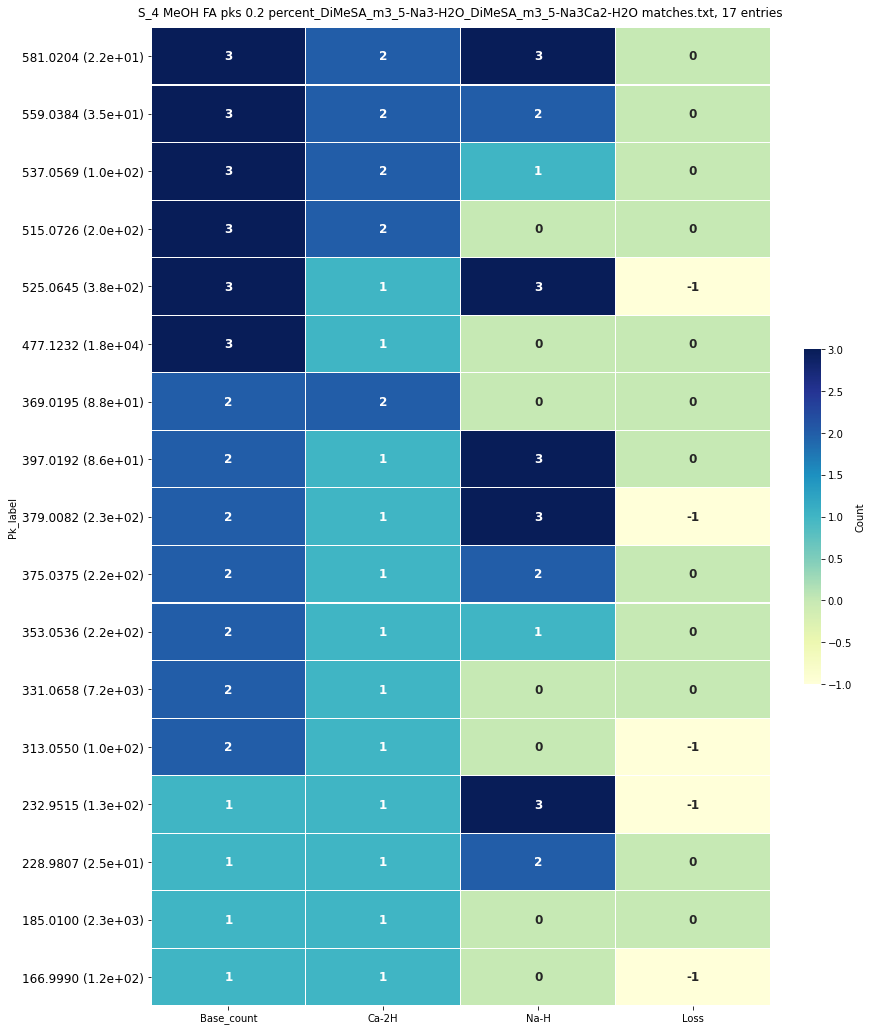

In [21]:
# Get the columns we want to use and sort by...
common_cols_in_use = [c for c in common_adducts if c in adduct_cols]

cols_to_use = ['Pk_label','Base_count'] + unusual_adducts + common_cols_in_use

sort_order = ['Base_count'] + unusual_adducts + common_cols_in_use

if has_loss:
    sort_order = sort_order + ['Loss']     # loss will be the last field sorted...if it exists
    cols_to_use = cols_to_use + ['Loss']
    
print(sort_order)
    
adduct_df = mono_df[cols_to_use]
adduct_df = adduct_df.set_index("Pk_label")   #this is so this field will be used to label the rows and won't be part of the map

# we set the loss to zero or -1...this way the same row with and without loss will be sorted next ti each other
if has_loss:
    adduct_df['Loss'] = adduct_df['Loss'].apply(lambda x: -1 if x else 0)  # if there's an entry it get sets to -1 otherwsie 0
    
adduct_df = adduct_df.sort_values(by = sort_order, ascending=False)   

base_counts_to_show = [] # can limit if desired e.g. [1,2,3,4,5]

if base_counts_to_show:
    to_plot = adduct_df[adduct_df.Base_count.isin(base_counts_to_show)]  # extract only the ones we want
    title_str = f'{match_file}, base counts {base_counts_to_show}, {to_plot.shape[0]} entries'
else: 
    to_plot = adduct_df
    title_str = f'{match_file}, {to_plot.shape[0]} entries'

# print(adduct_df.head())
f_size = 12    # fontisze for annotation and labels - depends on number of rows and columns
#
fig, ax = plt.subplots(figsize=(12,18))         # Sample figsize 
g = sns.heatmap(to_plot, ax=ax, cmap="YlGnBu", annot=True, linewidths=.1, annot_kws={'fontsize':f_size, "weight": "bold"},   #or "RdPu"
           cbar_kws={'label': 'Count', 'fraction':0.025, 'shrink': 0.6, 'orientation':'vertical'})

y_labs = g.get_yticklabels()
g.set_yticklabels(y_labs, size = f_size);
g.set_title(title_str,y=1.005)

## Visualize as Pivot Tables

These are easy to arrange based on the columns (cols) and indexes (inx) used which must come from the available columns. The display can show peak intensity, peak mass or both (depending on the way 'value_columns' is set), but the colouring and labelling are based on all values which may not be ideal so it is often best to display them separately as shown below amd display elsewhere. An intensity threshold can be used ( = 0 below) to reduce the number of entries in more complex plots.

Need to be careful with the aggfunc if cells are aggregated because not all columns are used, e.g. there is a 'Loss' couln but it is not specifically called out

In [22]:
# Print the available colums for use with the pivot tables...'Base_count' is always available; 'Loss' is available if appropriate
# This is only to allow review 
print('Columns available', cols_to_use)

Columns available ['Pk_label', 'Base_count', 'Ca-2H', 'Na-H', 'Loss']


In [23]:
# Use pivot table...these are easy to re-arrange by changing cols and inx
thresh = 0

subset = mono_df[(mono_df.Pk_inten > thresh)]   # apply threshold

title_str = f'{match_file}, inten > {thresh}, {subset.shape[0]}/{mono_df.shape[0]} entries, bpi {base_inten:.1f}'

cols = ['Base_count','Ca-2H']
inx = ['Na-H', 'Loss']    # or, for example, ['Na-H', 'Loss']

# We can change the formatting based on the columns/index displayed, e.g
show_rel = False
if show_rel:
    value_cols = ['Rel_inten']    # or ['Rel_inten', 'Pk_mass']
    val_fmt_string = '{0:.4f}'    # displayed value format - use '{0:.0f}' for inten, '{0:.4f}' for rel_inten
else:
    value_cols = ['Pk_inten']    #['Pk_inten']
    val_fmt_string = '{0:.0f}'    # displayed value format - use '{0:.0f}' for inten, '{0:.4f}' for rel_inten

# Need to be careful with aggfunc. This is used to combine cells that aren't seaparated by the seetings of columsn and indices - see notes
# Max is OK for intensities
#
# This is a recommended way to apply multiple parameters
# fill_value = 0  will replace NaNs with 0, but it's nicer to leave them and use the format statement to hide them with na_rep="")
# highligh_null = "white" to avoid having black cells.
pd.pivot_table(subset, index=inx, values=value_cols, columns=cols, aggfunc=np.max)  \
            .style  \
            .set_properties(**{'border':'1px solid black'})  \
            .set_table_styles([{'selector' : 'th', 'props' : [('border', '1px solid black')]}])  \
            .format(val_fmt_string, na_rep="")       \
            .background_gradient(cmap='YlGn', low=0.0, axis=None)   \
            .highlight_null('white')  \
            .set_caption(title_str)
  

In [24]:
# By mass - use the highest value from the cell which will be the one without a loss if there is more than one
# count also use len(x) to count the number that are being combined
# Don't need 'background_gradient' or 'highlight_null'- cells are just white
pd.pivot_table(subset, index=inx, values=['Pk_mass'], columns=cols, aggfunc=lambda x: max(x)) \
            .style  \
            .set_properties(**{'color':'black', 'border':'1px solid black'})  \
            .set_table_styles([{'selector' : 'th', 'props' : [('border', '1px solid black')]}])  \
            .format('{0:.3f}', na_rep="-")       \
            .set_caption(title_str)
  

In [25]:
# By pk_label - don't need a formatter becuase these are already strings
pd.pivot_table(subset, index=inx, values=['Pk_label'], columns=cols, aggfunc='last', fill_value="-") \
            .style  \
            .set_properties(**{'color':'black', 'border':'1px solid black'})  \
            .set_table_styles([{'selector' : 'th', 'props' : [('border', '1px solid black')]}])  \
            .set_caption(title_str)
  

In [14]:
#If all fields are used (i.e. nothing to aggregate) can use a simple pivot:
# pd.pivot(subset, index=inx, values=['Pk_label'], columns=cols)  # WARNING! This will cause an error if some columns are combined
